# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'VLTO', 'SW', 'SOLV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425247   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651133   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004158   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302032   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211014  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131149  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[985955 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.425240   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651133   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.004162   52.790001   54.189999   51.880001   53.099998   
           ABT      33.302036   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131134  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001082        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.057368        NaN       NaN   
           ABT      12287500.0         -0.010064        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146742  4.485761   
           YUM       1500600.0         -0.000051  36.057162  4.811707   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623469  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.782210  
           AAL          NaN       NaN       NaN       NaN     279.420040  
           AAPL         NaN       NaN       NaN       NaN    7234.160810  
           ABBV         NaN       NaN       NaN       NaN     462.394250  
           ABT          NaN       NaN       NaN       NaN     409.198771  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.033800 -2.159188     117.344880  
           YUM     4.841672  4.871637  0.142547 -1.363695     183.389836  
           ZBH     4.785551  4.825217 -0.381708 -0.881067     402.696470  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.212559  5.271371  0.651515 -1.188277     256.251875  

[985955 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [6]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.740905   38.950893         -0.002098  73.421476   
           AAL        287.915786   39.429928         -0.000966  40.718952   
           AAPL      4023.983948   26.854136         -0.003307  55.537335   
           ABBV       334.491192   40.025837         -0.062372  49.376848   
           ABT        210.542073   38.091473         -0.011927  56.962452   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.361755   78.356499         -0.000097  33.116223   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.670369  107.862030          0.000131  55.245485   
           GEHC       212.197215   66.105721          0.000185  40.922335   
           KVUE       670.804278   20.006195         -0.000159  35.706351   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.544191  3.616636  3.689080 -1.033887  0.567157  
           AAL     3.672028  3.749832  3.827636  0.190822 -0.418772  
           AAPL    3.281679  3.324991  3.368302 -0.967900 -0.142789  
           ABBV    3.717771  3.766009  3.814247 -0.526809  0.145676  
           ABT     3.650901  3.672752  3.694603 -1.064842  0.335556  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.370137  4.415425  4.460712 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.652147  4.692320  4.732493 -0.436215  0.366876  
           GEHC    4.155071  4.212607  4.270142 -0.893478 -1.116463  
           KVUE    3.014275  3.089221  3.164168 -0.899746 -1.435620  

[46553 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [7]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134331         -0.000176  62.203556  3.604673   
           AAPL     26.212479         -0.002468  49.891133  3.294237   
           ABBV     39.878788         -0.049190  27.477780  3.744517   
           ABT      34.112476         -0.008074  38.008813  3.549492   
           ACN     103.117393         -0.005023  53.823660  4.633009   
...                       ...               ...        ...       ...   
2023-09-30 XOM     113.372101         -0.000065  59.440183  4.687091   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           CRWD    160.479996          0.000144  51.534803  5.026187   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.402199  1.131597  
           AAPL    3.323117  3.351997 -1.038688 -0.195978  
           ABBV    3.798670  3.852822 -0.893132 -0.760593  
           ABT     3.599959  3.650426 -1.035224 -0.650888  
           ACN     4.644646  4.656283 -0.996806 -0.135456  
...                     ...       ...       ...       ...  
2023-09-30 XOM     4.727187  4.767283  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           CRWD    5.103696  5.181204 -0.744862  0.245950  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [113]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534168  1.011062  3.994389  3.849110  3.921750   
           AAPL     39.870972 -0.906642  3.692324  3.598569  3.645447   
           ABBV     69.460686  0.375557  4.317799  4.225041  4.271420   
           ABT      49.240391 -1.040044  3.954699  3.907545  3.931122   
           ACN     130.915802 -0.986514  4.893594  4.814228  4.853911   
...                       ...       ...       ...       ...       ...   
2023-09-30 VRTX    351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ       32.990002 -1.078816  3.584371  3.519855  3.552113   
           WFC      40.650002 -0.558742  3.798900  3.718132  3.758516   
           WMT     162.500000 -0.196379  5.116986  5.081613  5.099300   
           XOM     116.410004  0.601335  4.793504  4.713293  4.753399   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.018697  41.051784  -0.014108   
           AAPL           -0.000892 -0.039275  69.196833   0.096808   
           ABBV           -0.027715  0.473814  55.247862   0.022728   
           ABT            -0.003906  0.276133  53.844941   0.021276   
           ACN            -0.003066  0.352342  69.365078   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 VRTX            0.000037  0.027907  52.406728   0.009617   
           VZ              0.000056 -0.350385  42.222486  -0.056890   
           WFC             0.000234 -0.282325  40.920273  -0.015500   
           WMT             0.000024  0.399459  54.722508  -0.000676   
           XOM             0.000045  1.400623  59.440192   0.046947   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 VRTX    -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ      -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  

[10347 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [127]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0021  0.0089 -0.0322  -0.014108
           AAPL    0.0225 -0.0194  0.0021  0.0089 -0.0322   0.096808
           ABBV    0.0225 -0.0194  0.0021  0.0089 -0.0322   0.022728
           ABT     0.0225 -0.0194  0.0021  0.0089 -0.0322   0.021276
           ACN     0.0225 -0.0194  0.0021  0.0089 -0.0322   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0366 -0.0105  0.0341 -0.0241  -0.011353
           VZ     -0.0239 -0.0366 -0.0105  0.0341 -0.0241   0.026408
           WFC    -0.0239 -0.0366 -0.0105  0.0341 -0.0241  -0.098506
           WMT    -0.0239 -0.0366 -0.0105  0.0341 -0.0241   0.020819
           XOM    -0.0239 -0.0366 -0.0105  0.0341 -0.0241   0.045333

[10201 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [128]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0021  0.0089 -0.0322  -0.014108
           AAPL    0.0225 -0.0194  0.0021  0.0089 -0.0322   0.096808
           ABBV    0.0225 -0.0194  0.0021  0.0089 -0.0322   0.022728
           ABT     0.0225 -0.0194  0.0021  0.0089 -0.0322   0.021276
           ACN     0.0225 -0.0194  0.0021  0.0089 -0.0322   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-08-31 VRTX   -0.0239 -0.0366 -0.0105  0.0341 -0.0241  -0.011353
           VZ     -0.0239 -0.0366 -0.0105  0.0341 -0.0241   0.026408
           WFC    -0.0239 -0.0366 -0.0105  0.0341 -0.0241  -0.098506
           WMT    -0.0239 -0.0366 -0.0105  0.0341 -0.0241   0.020819
           XOM    -0.0239 -0.0366 -0.0105  0.0341 -0.0241   0.045333

[10150 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [132]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-08-31 VRTX    0.503006 -0.421553 -0.448925  0.068358  0.901635
           VZ      0.302281 -0.232428  0.380260  0.314857 -0.052791
           WFC     1.137062  0.331286  1.980815 -0.406196 -1.448209
           WMT     0.739524 -0.257165 -0.527148 -0.119761  0.652941
           XOM     1.003439 -1.057739  1.726825 -0.667863 -0.328023

[10150 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [147]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10067 entries, (Timestamp('2017-10-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-09-30 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10067 non-null  float64
 1   bb_high           10067 non-null  float64
 2   bb_low            10067 non-null  float64
 3   bb_mid            10067 non-null  float64
 4   garman_klass_vol  10067 non-null  float64
 5   macd              10067 non-null  float64
 6   rsi               10067 non-null  float64
 7   return_1m         10067 non-null  float64
 8   return_2m         10067 non-null  float64
 9   return_3m         10067 non-null  float64
 10  return_6m         10067 non-null  float64
 11  return_9m         10067 non-null  float64
 12  return_12m        10067 non-null  float64
 13  Mkt-RF            10067 non-null  float64
 14  SMB               10067 non-null  floa

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

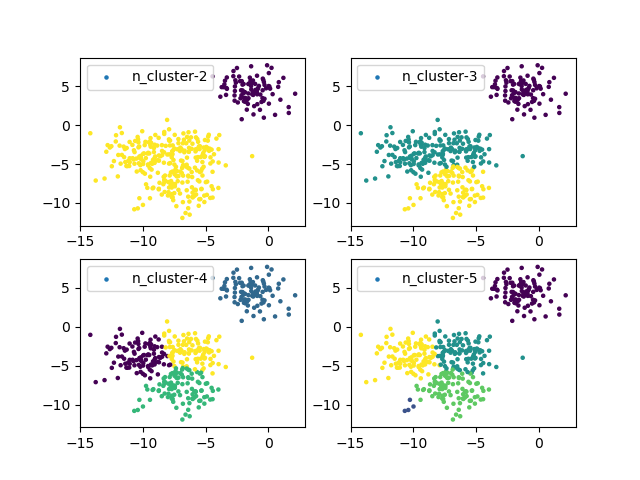

In [172]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.011062  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906642  3.692324  3.598569  3.645447         -0.000892   
           ABBV    0.375557  4.317799  4.225041  4.271420         -0.027715   
           ABT    -1.040044  3.954699  3.907545  3.931122         -0.003906   
           ACN    -0.986514  4.893594  4.814228  4.853911         -0.003066   
...                     ...       ...       ...       ...               ...   
2023-09-30 VRTX    0.029799  5.879295  5.838959  5.859127          0.000037   
           VZ     -1.078816  3.584371  3.519855  3.552113          0.000056   
           WFC    -0.558742  3.798900  3.718132  3.758516          0.000234   
           WMT    -0.196379  5.116986  5.081613  5.099300          0.000024   
           XOM     0.601335  4.793504  4.713293  4.753399          0.000045   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.018697  41.051784  -0.014108   0.022981  -0.023860   
           AAPL   -0.039275  69.196833   0.096808   0.015250   0.044955   
           ABBV    0.473814  55.247862   0.022728   0.098590   0.091379   
           ABT     0.276133  53.844941   0.021276   0.034308   0.034801   
           ACN     0.352342  69.365078   0.064180   0.048454   0.037202   
...                     ...        ...        ...        ...        ...   
2023-09-30 VRTX    0.027907  52.406728   0.009617  -0.000923  -0.000208   
           VZ     -0.350385  42.222486  -0.056890  -0.016122  -0.033458   
           WFC    -0.282325  40.920273  -0.015500  -0.057917  -0.013554   
           WMT     0.399459  54.722508  -0.000676   0.010014   0.012354   
           XOM     1.400623  59.440192   0.046947   0.046139   0.030496   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265237  1.312221   
           AAPL     0.028875   0.038941    0.035228  1.281431 -0.277562   
           ABBV     0.056495   0.047273    0.044026  0.495848  0.367241   
           ABT      0.038672   0.031320    0.029294  0.831377 -0.210089   
           ACN      0.028692   0.027398    0.018728  1.198741 -0.158879   
...                      ...        ...         ...       ...       ...   
2023-09-30 VRTX     0.018495   0.022140    0.016337  0.531730  0.038467   
           VZ      -0.021495  -0.014100   -0.006158  0.515775 -0.359821   
           WFC      0.016712   0.000702    0.003255  1.092617 -0.133888   
           WMT      0.017574   0.016553    0.020256  0.617915 -0.457738   
           XOM      0.012838   0.008747    0.027037  1.165608  0.359102   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.610074  0.477110  0.572275        1  
           AAPL   -0.598007  0.646021  0.479100        3  
           ABBV   -0.024674  0.227999  0.139847        2  
           ABT    -0.533317  0.245619  0.973717        2  
           ACN    -0.330940  0.263185  0.177219        3  
...                     ...       ...       ...      ...  
2023-09-30 VRTX   -0.951157  0.143830  0.862092        2  
           VZ      0.021296  0.306406  0.605811        1  
           WFC     1.325202 -0.749272 -0.431551        1  
           WMT    -0.305926  0.412462  0.737715        2  
           XOM     0.537087 -0.480681  0.790825        3  

[10067 rows x 19 columns]

In [173]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [171]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [370]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  '

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [371]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [372]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.316149   41.419556  34.821724  104.783096   
2016-11-01  38.363201   25.840994   41.917068  34.653122  104.692986   
2016-11-02  38.276459   25.864183   42.169540  34.342529  106.919510   
2016-11-03  38.054203   25.586943   41.501225  34.058559  105.423119   
2016-11-04  38.402088   25.356310   41.612629  34.688618  105.675537   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  176.080002  154.649994  97.470001  316.989990   
2023-09-26  12.700000  171.960007  153.910004  96.230003  310.609985   
2023-09-27  12.610000  170.429993  153.130005  95.529999  314.380005   
2023-09-28  12.920000  170.690002  152.250000  98.120003  300.769989   
2023-09-29  12.810000  171.210007  149.059998  96.849998  307.109985   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   75.138802   72.279999  51.253304   26.757372  ...   
2016-11-01  106.870003   75.017982   70.099998  50.406013   26.591753  ...   
2016-11-02  105.889999   77.658951   68.680000  50.298012   26.306513  ...   
2016-11-03  107.169998   77.097977   67.610001  48.304379   26.012074  ...   
2016-11-04  106.199997   76.882202   69.440002  47.664745   25.966064  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  240.020004  205.669998  62.130001  136.589996  ...   
2023-09-26  506.299988  237.240005  201.660004  61.259998  134.080002  ...   
2023-09-27  502.600006  242.630005  202.279999  61.009998  135.059998  ...   
2023-09-28  504.670013  243.309998  207.889999  61.279999  138.220001  ...   
2023-09-29  509.899994  240.580002  206.910004  60.599998  138.449997  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                        
                WMT     WYNN       XOM  
Date                                    
2016-10-31  6389000  1341600  16663800  
2016-11-01  8838600  3722300  13050600  
2016-11-02  7645300  2542400  11226100  
2016-11-03  6803900  9050400   8836500  
2016-11-04  7262100  3223800  13877100  
...             ...      ...       ...  
2023-09-25  3486500  1387800  11316000  
2023-09-26  4811900  1454000  11805400  
2023-09-27  5237000  2050000  23976200  
2023-09-28  3872400  1290400  16808100  
2023-09-29  6279300  1326800  18810700  

[1740 rows x 918 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [373]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001481
2017-11-02,0.002892
2017-11-03,0.006382
2017-11-06,0.002932
2017-11-07,0.002917
...,...
2023-09-25,0.003587
2023-09-26,-0.011112
2023-09-27,0.004989


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [374]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001481,0.001321
2017-11-02,0.002892,0.000388
2017-11-03,0.006382,0.003333
2017-11-06,0.002932,0.001547
2017-11-07,0.002917,-0.000696
...,...,...
2023-09-25,0.003587,0.004196
2023-09-26,-0.011112,-0.014800
2023-09-27,0.004989,0.000399
2023-09-28,0.007681,0.005781


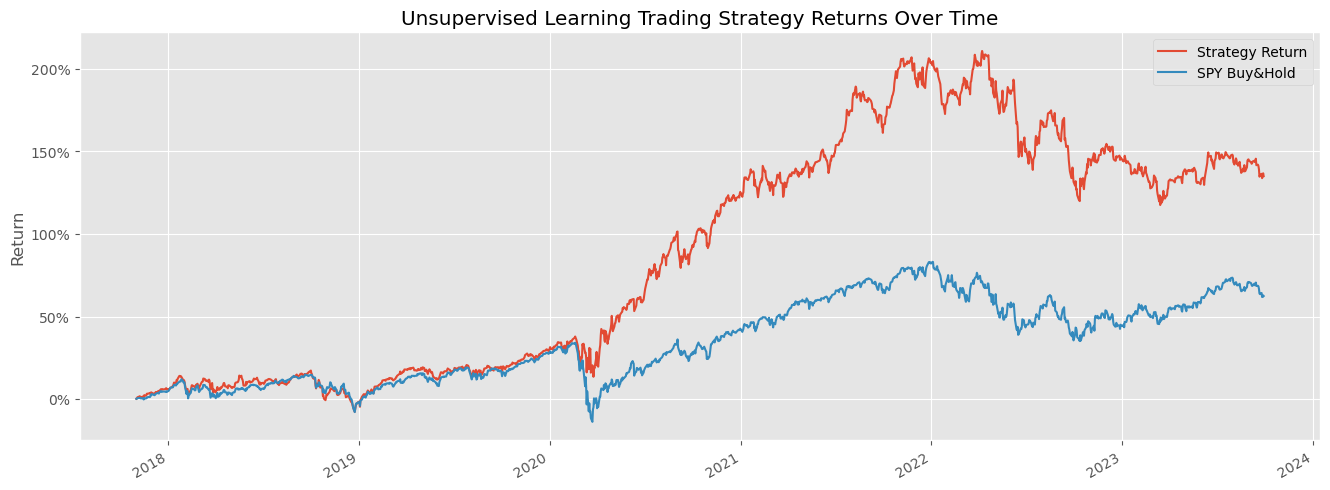

In [375]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
